Saving img.jpg to img.jpg
Saving img_depth.jpg to img_depth.jpg
Saving img_style.jpg to img_style.jpg


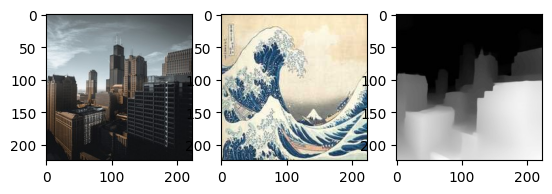

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import tensorflow as tf
from google.colab import files
from io import BytesIO
from PIL import Image
from scipy import signal
from tensorflow import keras

upl = files.upload()
img = Image.open(BytesIO(upl['img.jpg']))
img_style = Image.open(BytesIO(upl['img_style.jpg']))
img_depth = matplotlib.image.imread(BytesIO(upl['img_depth.jpg']), 0)

plt.subplot(1, 3, 1)
plt.imshow( img )
plt.subplot(1, 3, 2)
plt.imshow( img_style )
plt.subplot(1, 3, 3)
plt.imshow( img_depth, cmap = 'gray')
plt.show()

In [2]:
# Функция свертки матрицы коэффициентов
def conv2a(x):
  y = np.array([[1., 1., 1.],
                [1., 1., 1.],
                [1., 1., 1.]])
  grad = signal.convolve2d(x, y, mode='same')
  for i in range(0, len(grad)):
    k = len(grad)-1
    # Вычисление средний коэффициентов
    if (i == 0) or (i == k):
      grad[i][::k] = grad[i][::k]/4
      grad[i][1:k] = grad[i][1:k]/6
    else:
      grad[i][::k] = grad[i][::k]/6
      grad[i][1:k] = grad[i][1:k]/9
  return grad

# Функция подвыборки матрицы
def maxpooling2a(mat):
  M, N = mat.shape
  K = 2; L = 2
  MK = M // K; NL = N // L
  return(mat[:MK*K, :NL*L].reshape(MK, K, NL, L).max(axis=(1, 3)))

# Функция представления матрицы коэффициентов на слое block5_conv2
def block5_conv2a(x):
  max1 = maxpooling2a(conv2a(conv2a(x)))
  max2 = maxpooling2a(conv2a(conv2a(max1)))
  max3 = maxpooling2a(conv2a(conv2a(conv2a(conv2a(max2)))))
  max4 = maxpooling2a(conv2a(conv2a(conv2a(conv2a(max3)))))
  return conv2a(conv2a(max4))

gradx = block5_conv2a(np.around(img_depth))
gradx = np.swapaxes(gradx, 0, 1)
new = np.zeros((512, 14, 14))
for i in range(len(new)):
  new[i] = gradx
grada = np.swapaxes(new, 0, 2)

In [3]:
# Преобразование изображений для восприятия сетью VGG-19
x_img = keras.applications.vgg19.preprocess_input( np.expand_dims(img, axis=0) )
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

# Функция обратного преобразования изображения из представления сети VGG-19
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

# Загружаем сеть VGG-19
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Слой контента, куда будут вытягиваться карты объектов
content_layers = ['block5_conv2']

# Слои стилей, которые нас интересует
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Определяем выходные слои
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

print(vgg.input)
for m in model_outputs:
  print(m)

# Создаем модель нейронной сети VGG-19
model = keras.models.Model(vgg.input, model_outputs)
for layer in model.layers:
    layer.trainable = False
print(model.summary())
# Функция формирования представлений изображений для модели
def get_feature_representations(model):
  style_outputs = model(x_style)
  content_outputs = model(x_img)
  # Получаем представление функций стиля и контента из нашей модели.
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

# Функция потерь по контенту
def get_content_loss(base_content, target):
  return tf.reduce_mean(grada*tf.square(base_content - target))

# Функция вычисления матрицы Грамма
def gram_matrix(input_tensor):
  # We make the image channels first
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

# Функция потерь по стилю
def get_style_loss(base_style, gram_target):
  gram_style = gram_matrix(base_style)
  return tf.reduce_mean(tf.square(gram_style - gram_target))

# Функция всех потерь
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  model_outputs = model(init_image)
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  style_score = 0; content_score = 0
  # Накапливаем потери стиля со всех слоев
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
  # Накапливаем потери контента со всех слоев
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  style_score *= style_weight
  content_score *= content_weight
  # Общии потери
  loss = style_score + content_score
  return loss, style_score, content_score

80134624/80134624 [==============================] - 4s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block

tf.Tensor(5680954.0, shape=(), dtype=float32)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-4-587b5a9596d5>:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


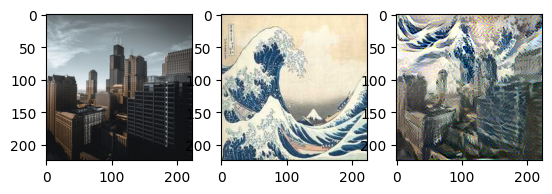

In [4]:
num_iterations=2000
content_weight=1e2
style_weight=1e-2

# Формируем карты признаков по контенту и по стилю
style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
# Начальное изображение
init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)
# Оптимизатор для градиентного спуска
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

# Нахождения локального минимума
for i in range(num_iterations):
    with tf.GradientTape() as tape:
       all_loss = compute_loss(**cfg)
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    #print(i, ', ', loss.numpy())
    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())
      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)


plt.imshow(best_img)
print(best_loss)

image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save("result.jpg")
files.download("result.jpg")

plt.subplot(1, 3, 1)
plt.imshow( img )
plt.subplot(1, 3, 2)
plt.imshow( img_style )
plt.subplot(1, 3, 3)
plt.imshow( best_img)
plt.show()